<a href="https://colab.research.google.com/github/yukliio/stemcamp.aistation/blob/main/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem statement

# Step 1: importing the Dataset

In [1]:
!pip install kagglehub

In [7]:
# put git script to connect to repo here (will put in env soon)


Cloning into 'stemcamp.aistation'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 31 (delta 12), reused 6 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 5.39 KiB | 5.39 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/stemcamp.aistation


In [8]:
from google.colab import files
files.upload() # add kaggle.json file here

{}

In [9]:
# create a kaggle folder and download the pnenomia dataset
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -al ~/.kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -o chest-xray-pneumonia.zip -d chest_xray

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/chest_xray/train

In [10]:
import numpy as np
from PIL import Image

import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
torch.manual_seed(42)

In [33]:
# load dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])
train_dataset = datasets.ImageFolder(root='/content/stemcamp.aistation/chest_xray/chest_xray/train', transform=transform)
print(train_dataset.class_to_idx)
labels = list(train_dataset.class_to_idx.keys())

train_dataset[0][0].shape
len(train_dataset[0][0][0])

{'NORMAL': 0, 'PNEUMONIA': 1}
['NORMAL', 'PNEUMONIA']


224

In [13]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
def get_mean_std(loader):
    # VAR[X] = E[X**2] - E[X]**2
    channels_sum = 0
    channels_squared_sum = 0
    num_batches = 0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


In [14]:
mean, std = get_mean_std(train_loader)
print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.4824])
Std: tensor([0.2361])


In [16]:
normal_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
train_dataset_normal = datasets.ImageFolder(root='/content/stemcamp.aistation/chest_xray/chest_xray/train', transform=normal_transform)
val_dataset_normal = datasets.ImageFolder(root='/content/stemcamp.aistation/chest_xray/chest_xray/val', transform=normal_transform)
test_dataset_normal = datasets.ImageFolder(root='/content/stemcamp.aistation/chest_xray/chest_xray/test', transform=normal_transform)

train_loader = DataLoader(train_dataset_normal, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset_normal, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset_normal, batch_size=64, shuffle=True)


In [17]:
# test the normalization
images, _ = next(iter(train_loader))
print("Batch mean:", images.mean().item())
print("Batch std:", images.std().item())

Batch mean: -0.03910244628787041
Batch std: 0.9981245994567871


In [18]:
image, label = train_dataset_normal[0]
image.size()

torch.Size([1, 224, 224])

# Viualizing our data

Image shape: torch.Size([1, 224, 224])


Text(0.5, 1.0, 'NORMAL')

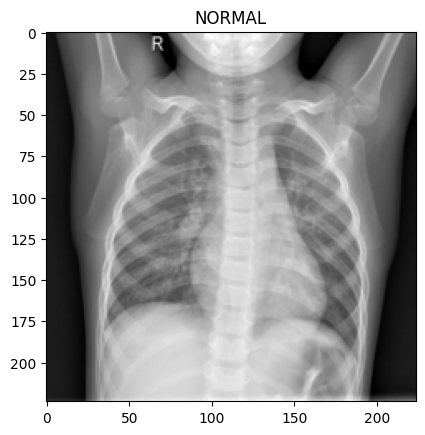

In [34]:
import matplotlib.pyplot as plt
image, label = train_dataset_normal[0]

print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="grey")
plt.title(labels[label])

# Building the model